## Application of Neural Networks to AI Accelerometer data stream

This code is based on the neural networks ipython notebook generated by KJ for the October, 2021 analysis of EPRI Flow Data. The version here is meant to process AI Accelerometer data and look for the changes to the data stream produced by physical anomalies, as indicated by the notebook provided by Lea Boche and Christina Lawson (EPRI). 

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler 
import sys
sys.path.append('/Users/j.wagg/DataScience/S2DS/EPRI/NewData2022/Logs')
from lablog_parser import *
from custom_metric import *


pd.set_option("display.max.columns", None)

In [19]:
anomfile = "/Users/j.wagg/DataScience/S2DS/EPRI/NewData2022/Logs/Lablog_processed.xlsx"
anom_list = read_anomalies(anomfile, sheets="all")

In [20]:
# reading in the accelerometer data, note that the 'RealValue' column is the one to look at
df1 = pd.read_csv('20220726 eidb.csv')
df1['Date_Time'] =  pd.to_datetime(df1['Date_Time'])

In [21]:
print(df1['Date_Time'])

0       2022-07-08 18:59:13
1       2022-07-08 18:59:13
2       2022-07-08 18:59:13
3       2022-07-08 18:59:13
4       2022-07-08 18:59:13
                ...        
26176   2022-07-26 10:09:36
26177   2022-07-26 10:09:36
26178   2022-07-26 10:09:36
26179   2022-07-26 10:09:36
26180   2022-07-26 10:09:36
Name: Date_Time, Length: 26181, dtype: datetime64[ns]


/Users/j.wagg/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


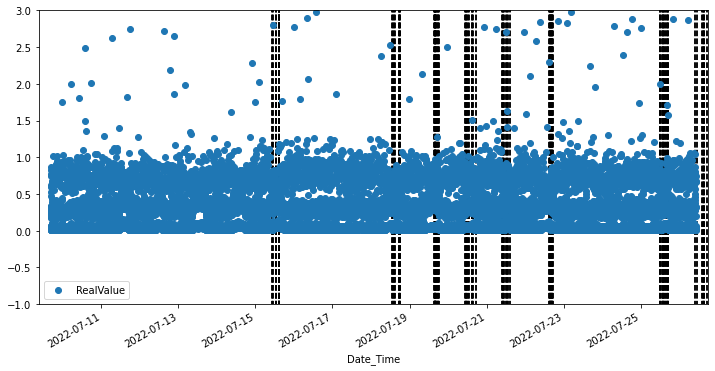

In [22]:
# see if there are any clear correlations betweem the anomalies and the changes to the accelerometer signal 
plt.rcParams['figure.figsize'] = [12, 6]
df1.plot(x='Date_Time', y='RealValue', marker="o",linestyle='None') 
plt.xlim(["2022-07-09 9:00", "2022-07-26 18:00"])
plt.ylim([-1, 3])

for i,j,k in anom_list:
    event_begin = pd.to_datetime(j)
    event_end = pd.to_datetime(j)
    plt.vlines([event_begin, event_begin], -2, 8, colors='black', linestyles='dashed' )
plt.show()

In [23]:
# add a new column to the data frame so that anomalies appear as binary 1 yes/0 no anomaly
# we can then use this for the Neural Network
df1['bin_anomaly'] = 0
df1['anom_type'] = 'None'

for index in df1.index:
    time = df1['Date_Time'][index]
    for i,j,k in anom_list:
        event_begin = pd.to_datetime(j)
        event_end = pd.to_datetime(k)
        #print(event_begin,event_end)
        if j != None and k != None:
            if (time >= event_begin and time < event_end): 
                df1.at[index,'bin_anomaly'] = 1
                df1.at[index,'anom_type'] = i

In [24]:
df1['bin_anomaly'].describe()

count    26181.000000
mean         0.018678
std          0.135387
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: bin_anomaly, dtype: float64

## Neural Network binary approach to classification of anomalies

In [25]:
drop_list = ['ID', 'Date_Time', 'PointIndex','Axis', 'Units','FileID', 'Reason', 'SyncID', 'anom_type']

value = 'bin_anomaly'
print(df1['bin_anomaly'].describe())

count    26181.000000
mean         0.018678
std          0.135387
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: bin_anomaly, dtype: float64


   Severity  RealValue  bin_anomaly
0  2.017857   1.150000            0
1  1.383929   0.430000            0
2  1.250000   0.280000            0
3 -1.000000   0.072792            0
4  1.718162   0.804342            0
Accuracies
accuracy_score on train dataset :  0.9810446906035142
accuracy_score on test dataset :  0.982432690471644


Classification report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5145
           1       0.00      0.00      0.00        92

    accuracy                           0.98      5237
   macro avg       0.49      0.50      0.50      5237
weighted avg       0.97      0.98      0.97      5237





/Users/j.wagg/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/j.wagg/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/j.wagg/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


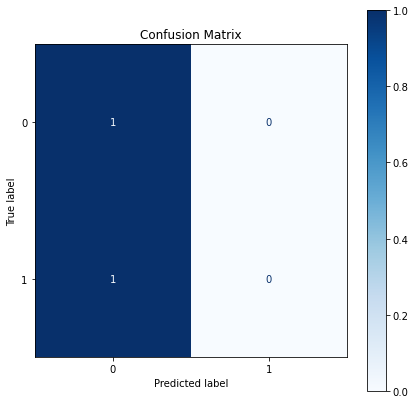

In [10]:
# Begin with binary classification approach

scaler = StandardScaler()  

#drop the columns we don't need
df = df1.drop(drop_list, axis=1)

print(df.head())
    
#define features and value
X = df.drop(value, axis=1)
y = df[value]

#create train and test datasets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20, random_state = 100)

scaler.fit(X_train) 

X_train = scaler.transform(X_train)  
X_val = scaler.transform(X_val)
X = scaler.transform(X)


#train the model
model5 = MLPClassifier(random_state = 100, max_iter=1500)
    
model5.fit(X_train,y_train)
    
    
#calculate accuracy
predict_train = model5.predict(X_train)
predict_val = model5.predict(X_val)
accuracy_train = accuracy_score(y_train,predict_train)
print("Accuracies")
print('accuracy_score on train dataset : ', accuracy_train)
accuracy_val = accuracy_score(y_val,predict_val)
print('accuracy_score on test dataset : ', accuracy_val)
print('\n')
    
    
#print classification report
print('Classification report')
print(classification_report(y_val, predict_val))
print('\n')
    
#print normalized confusion matrix   
matrix = plot_confusion_matrix(model5, X_val, y_val, cmap=plt.cm.Blues, normalize='true')
matrix.ax_.set_title('Confusion Matrix')
fig = plt.gcf()
fig.set_size_inches(7, 7)
plt.show()


In [26]:
#perform cross validation
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=100)

scores = cross_val_score(model5, X, y, cv=cv, n_jobs=-1)
print('Cross Validation accuracy scores: %s' % scores)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))
print('\n')

scores = cross_val_score(model5, X, y, cv=cv, n_jobs=-1, scoring=make_scorer(cedric_metric_binary, greater_is_better=True))
print('Cross Validation custom metric scores: %s' % scores)
print('Cross Validation custom metric: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Cross Validation accuracy scores: [0.98243269 0.97995035 0.9805232  0.97765897 0.98166889 0.98166889
 0.98185984 0.97823181 0.98281459 0.98491503]
Cross Validation accuracy: 0.981 +/- 0.002


Cross Validation custom metric scores: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Cross Validation custom metric: 0.000 +/- 0.000
